In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
#IMPORT PACKAGES
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision.io import read_image
import torchvision.transforms as T
import random
from torch import Tensor

from google.colab import drive
drive.mount('/content/gdrive')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Mounted at /content/gdrive


In [ ]:
#CUSTOM DATASET CLASS DATASET
class HAM10000(Dataset):
  """HAM10000 Dataset"""

  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
    """
    Args:
      csv_file (string): Path to the csv file with the metadata/labels for images.
      img_dir (string): Directory with all the images.
      transform (callable, optional): Optional transform to be applied
          on the image of a sample.
      target_transform (callable, optional): Optional transform to be
          applied on the features of the sample.
    """
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, index):
    #get image
    img_name = os.path.join(self.img_dir, (self.img_labels['image_id'][index] + '.jpg'))
    image = read_image(img_name)/255
    image = torch.tensor(image, dtype=torch.float32)


    #get metadata
    label = self.img_labels['dx'][index]
    # label = np.array([label], dtype=np.int8)
    # label = torch.from_numpy(label)

    gender = self.img_labels['sex'][index]


    # #if transforms are to be performed on the sample, this will trigger them
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    if self.target_transform:
      fitzscale = self.target_transform(fitzscale)

    return image, label, gender

In [ ]:
workers = 2

batch_size = 32

image_size = 64

# num channels
nc = 3

# latent vector: size of the noise for generate fake images
nz = 100

# generator feature map
ngf = 32

# discriminator feature map
ndf = 32

num_epochs = 50

lr = 0.0002

beta1 = 0.5

ngpu = 1

## Data

In [ ]:
HAM10000_meta = pd.read_csv('/content/gdrive/MyDrive/CSC2529/HAM_train.csv')

In [ ]:
HAM_male_mel = HAM10000_meta[(HAM10000_meta.dx == 'mel') & (HAM10000_meta.sex == "male")]
HAM_female_mel = HAM10000_meta[(HAM10000_meta.dx == 'mel') & (HAM10000_meta.sex == "female")]

HAM_male_bkl = HAM10000_meta[(HAM10000_meta.dx == 'bkl') & (HAM10000_meta.sex == "male")]
HAM_female_bkl = HAM10000_meta[(HAM10000_meta.dx == 'bkl') & (HAM10000_meta.sex == "female")]

In [ ]:
HAM_male_mel = HAM_male_mel[['image_id', 'dx', 'sex']]
HAM_female_mel = HAM_female_mel[['image_id', 'dx', 'sex']]

HAM_male_bkl = HAM_male_bkl[['image_id', 'dx', 'sex']]
HAM_female_bkl = HAM_female_bkl[['image_id', 'dx', 'sex']]

In [ ]:
HAM_male_mel.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_train_male_mel.csv')

HAM_male_bkl.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_train_male_bkl.csv')


In [ ]:
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_train_male_mel.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32, shuffle=True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Model Setup

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# initialize the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# initialize the discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

# use Adam optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

### Male melanoma

#### Training model

In [ ]:
num_epochs = 100

In [ ]:
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_train_male_mel.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32, shuffle=True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/18]	Loss_D: 1.3538	Loss_G: 2.6356	D(x): 0.6421	D(G(z)): 0.5446 / 0.0797
[1/100][0/18]	Loss_D: 0.1293	Loss_G: 5.0436	D(x): 0.9563	D(G(z)): 0.0633 / 0.0085
[2/100][0/18]	Loss_D: 0.2034	Loss_G: 5.9439	D(x): 0.8625	D(G(z)): 0.0134 / 0.0032
[3/100][0/18]	Loss_D: 0.3598	Loss_G: 12.8604	D(x): 0.9765	D(G(z)): 0.2719 / 0.0000
[4/100][0/18]	Loss_D: 0.0238	Loss_G: 6.6315	D(x): 0.9800	D(G(z)): 0.0028 / 0.0017
[5/100][0/18]	Loss_D: 0.0162	Loss_G: 7.2950	D(x): 0.9972	D(G(z)): 0.0132 / 0.0008
[6/100][0/18]	Loss_D: 0.0187	Loss_G: 6.5683	D(x): 0.9910	D(G(z)): 0.0094 / 0.0015
[7/100][0/18]	Loss_D: 0.0171	Loss_G: 7.0660	D(x): 0.9963	D(G(z)): 0.0133 / 0.0010
[8/100][0/18]	Loss_D: 0.0127	Loss_G: 7.3486	D(x): 0.9967	D(G(z)): 0.0093 / 0.0007
[9/100][0/18]	Loss_D: 0.0094	Loss_G: 7.2653	D(x): 0.9972	D(G(z)): 0.0066 / 0.0008
[10/100][0/18]	Loss_D: 1.0778	Loss_G: 16.2911	D(x): 0.4885	D(G(z)): 0.0000 / 0.0000
[11/100][0/18]	Loss_D: 0.0402	Loss_G: 8.4772	D(x): 0.9703	D(G(z)): 0.

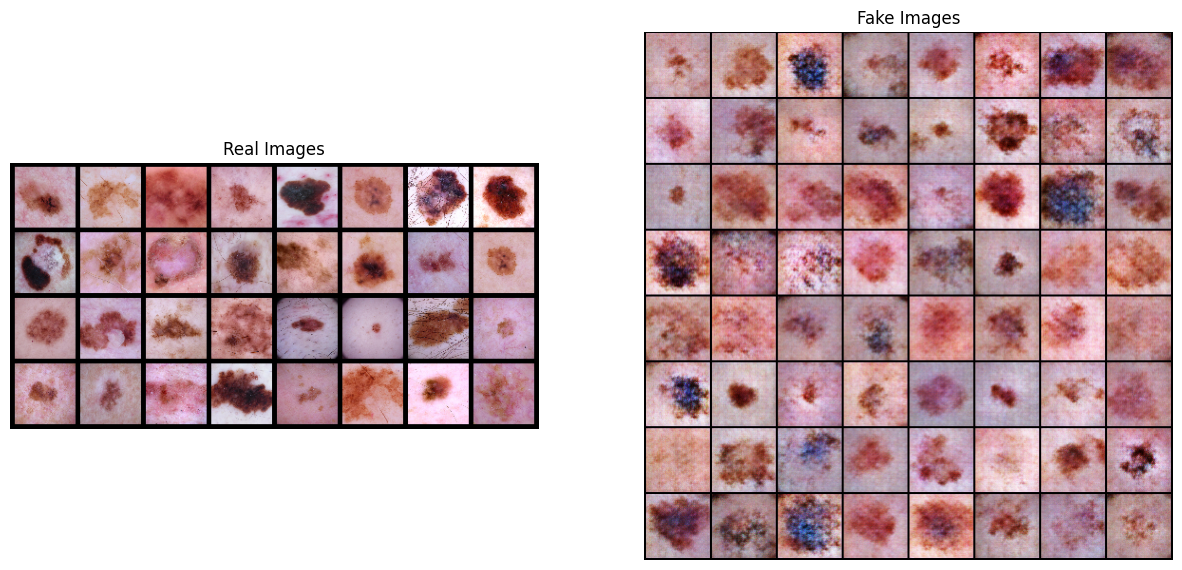

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
torch.save(netG.state_dict(), '/content/gdrive/MyDrive/CSC2529/generator_train_male_mel_100.pth')

#### Generate fake images

In [ ]:
netG.load_state_dict(torch.load('/content/gdrive/MyDrive/CSC2529/generator_train_male_mel_100.pth'))

<All keys matched successfully>

In [ ]:
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# generate fake images
with torch.no_grad():
  fake = netG(torch.randn(350, 100, 1, 1, device=device)).detach().cpu()

In [ ]:
# create hash as image names in saving
hash_list = []
for i in range(len(fake)):
  fake_img = vutils.make_grid(fake[i],normalize=True).permute(1,2,0)
  img_bytes = fake_img.numpy().tobytes()
  hash_md5 = hashlib.md5()
  hash_md5.update(img_bytes)
  digest = hash_md5.hexdigest()
  hash_list.append('GAN' + digest)

In [ ]:
GAN_male_mel = pd.DataFrame()

In [ ]:
GAN_male_mel['image_id'] = hash_list

In [ ]:
GAN_male_mel['sex'] = ['male'] * 350
GAN_male_mel['label'] = [1] * 350

In [ ]:
# create and save labels
GAN_male_mel

,image_id,sex,label
0,GAN2d89e70f543c5be67072c36adf0b844b,male,1
1,GANe7e2d0d6a952618341480f34a77889b6,male,1
2,GANdf5211c413e2605f8c8f1501dfbc0208,male,1
3,GAN165f52bef4d51671fea6a2bfee1e8dfe,male,1
4,GAN86d583ab49fdfa26e5768457b4a7e84a,male,1
...,...,...,...
345,GAN2d6758e396a7db762c9ef6333d23b308,male,1
346,GANde40906e50d27607ded696be8b5afe04,male,1
347,GANf3c6c576090a37c7fbac963e85df5571,male,1
348,GAN8ee5819d0aba62a570c63ee73a033d85,male,1


In [ ]:
GAN_male_mel.to_csv("/content/gdrive/MyDrive/CSC2529/GAN_aug_male_mel.csv")

In [ ]:
# saving images
for i in range(len(fake)):
  fake_img = vutils.make_grid(fake[i],normalize=True).permute(1,2,0)
  fake_img = Image.fromarray((fake_img.numpy()*255).astype(np.uint8))
  fake_img.save("/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/" + hash_list[i] + ".jpg")

## Male benign keratosis

In [ ]:
# load data
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_train_male_bkl.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32, shuffle=True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
num_epochs=120

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/120][0/16]	Loss_D: 1.4179	Loss_G: 1.1935	D(x): 0.4860	D(G(z)): 0.4678 / 0.3188
[1/120][0/16]	Loss_D: 0.3583	Loss_G: 2.4870	D(x): 0.9141	D(G(z)): 0.2244 / 0.0914
[2/120][0/16]	Loss_D: 0.2862	Loss_G: 3.4945	D(x): 0.8838	D(G(z)): 0.1282 / 0.0345
[3/120][0/16]	Loss_D: 0.3156	Loss_G: 4.1944	D(x): 0.8941	D(G(z)): 0.1708 / 0.0177
[4/120][0/16]	Loss_D: 0.1100	Loss_G: 4.3850	D(x): 0.9487	D(G(z)): 0.0540 / 0.0147
[5/120][0/16]	Loss_D: 0.1175	Loss_G: 4.5896	D(x): 0.9385	D(G(z)): 0.0420 / 0.0131
[6/120][0/16]	Loss_D: 0.1386	Loss_G: 4.5843	D(x): 0.9716	D(G(z)): 0.0983 / 0.0133
[7/120][0/16]	Loss_D: 1.1505	Loss_G: 7.7831	D(x): 0.9896	D(G(z)): 0.6272 / 0.0007
[8/120][0/16]	Loss_D: 0.2542	Loss_G: 3.9004	D(x): 0.8212	D(G(z)): 0.0311 / 0.0268
[9/120][0/16]	Loss_D: 1.9589	Loss_G: 5.8895	D(x): 0.1690	D(G(z)): 0.0008 / 0.0037
[10/120][0/16]	Loss_D: 0.1513	Loss_G: 4.5099	D(x): 0.9258	D(G(z)): 0.0685 / 0.0144
[11/120][0/16]	Loss_D: 0.5975	Loss_G: 3.4836	D(x): 0.8616	D(G(z)): 0.33

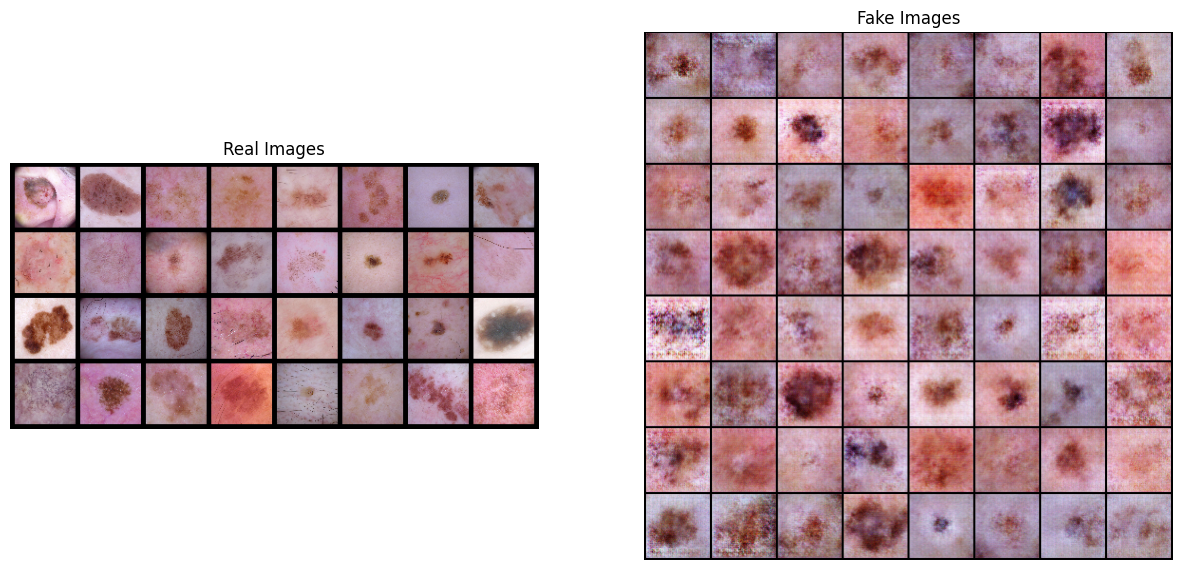

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
torch.save(netG.state_dict(), '/content/gdrive/MyDrive/CSC2529/generator_train_male_bkl_120.pth')

#### Generate fake images

In [ ]:
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# generate fake images
with torch.no_grad():
  fake = netG(torch.randn(350, 100, 1, 1, device=device)).detach().cpu()

In [ ]:
# create hash for each image for saving purposes
hash_list = []
  for i in range(len(fake)):
    fake_img = vutils.make_grid(fake[i],normalize=True).permute(1,2,0)
    img_bytes = fake_img.numpy().tobytes()
    hash_md5 = hashlib.md5()
    hash_md5.update(img_bytes)
    digest = hash_md5.hexdigest()
    hash_list.append('GAN' + digest)

In [ ]:
GAN_male_bkl = pd.DataFrame()

In [ ]:
GAN_male_bkl['image_id'] = hash_list

In [ ]:
GAN_male_bkl['sex'] = ['male'] * 350
GAN_male_bkl['label'] = [0] * 350

In [ ]:
# labels
GAN_male_bkl

,image_id,sex,label
0,GAN32cb8300fb3db8b48d701af17e9dc40c,male,0
1,GANa1d33691d0d4bef8258f932d479f2061,male,0
2,GAN5a16c82e9347b4dfac7e49281ce973ce,male,0
3,GAN560e47140ca2abc113141dc0a541dfd3,male,0
4,GANfe6568ddcce629e56383059119eaa34f,male,0
...,...,...,...
345,GANfea376a0db69b0029a9407c9d3209c57,male,0
346,GAN7129a907dc0e812f4586c83e3277b633,male,0
347,GANe8c1d87e852f37985c5856cebedc5647,male,0
348,GAN709bdb0140edcf3eb99c04a5594fd7ec,male,0


In [ ]:
GAN_male_bkl.to_csv("/content/gdrive/MyDrive/CSC2529/GAN_aug_male_bkl.csv")

In [ ]:
# saving images
for i in range(len(fake)):
  fake_img = vutils.make_grid(fake[i],normalize=True).permute(1,2,0)
  fake_img = Image.fromarray((fake_img.numpy()*255).astype(np.uint8))
  fake_img.save("/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/" + hash_list[i] + ".jpg")